In [67]:
import torch
import torch.nn as nn
from transformers import DetrImageProcessor, DetrForObjectDetection
from scipy.optimize import linear_sum_assignment

class TrackEmbeddingUpdater(nn.Module):
    def __init__(self, num_cameras, embed_dim=256, num_heads=8):
        super().__init__()
        self.num_cameras = num_cameras
        self.cross_attn = nn.ModuleList([
            nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
            for _ in range(num_cameras)
        ])
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, embed_dim)
        )

    def forward(self, track_embeds, detection_embeds):


        attn_outputs = []
        for cam_idx in range(self.num_cameras):
            #print("track_embeds", track_embeds.shape, "detection_embeds[cam_idx]", detection_embeds[cam_idx].shape)
            attn_out, _ = self.cross_attn[cam_idx](
                query=track_embeds,
                key=detection_embeds[cam_idx],
                value=detection_embeds[cam_idx]
            )
            attn_outputs.append(attn_out)
        aggregated = torch.mean(torch.stack(attn_outputs), dim=0)
        self_attn_out, _ = self.self_attn(aggregated, aggregated, aggregated)
        return self.ffn(self_attn_out)

class AssociationModule(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        self.detection_proj = nn.Linear(embed_dim, embed_dim)
        self.track_proj = nn.Linear(embed_dim, embed_dim)
        self.embed_dim = embed_dim
    def forward(self, detection_embeds, track_embeds):
        Q = self.detection_proj(detection_embeds)
        K = self.track_proj(track_embeds)
        return torch.softmax(torch.matmul(Q, K.transpose(1,2)) / (self.embed_dim**0.5), dim=-1)

class MCTR(nn.Module):
    def __init__(self, num_cameras=4, num_queries=100, embed_dim=256):
        super().__init__()
        self.detr = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
        for param in self.detr.parameters():
            param.requires_grad = False
        self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
        
        self.track_queries = nn.Embedding(num_queries, embed_dim)
        self.track_updater = TrackEmbeddingUpdater(num_cameras, embed_dim)
        self.associator = AssociationModule(embed_dim)
        
        self.detection_proj = nn.Linear(self.detr.config.d_model, embed_dim)
        self.register_buffer('active_tracks', None)

        nn.init.xavier_uniform_(self.track_queries.weight)

    def forward(self, multi_camera_views):
        #print(len(multi_camera_views), "Number of camera views:", len(multi_camera_views))
        #print("Shape of first camera view:", multi_camera_views[0])
        first_view = next(iter(multi_camera_views.values()))
        batch_size = first_view['pixel_values'].shape[0]        
        # Inicjalizacja śladów
        if self.active_tracks is None:
            self.active_tracks = self.track_queries.weight.unsqueeze(0).repeat(batch_size, 1, 1)

        # Przetwarzanie DETR dla każdej kamery
        detection_embeds = []
        detection_logits_list = []
        detection_boxes_list = []

        for view_num in sorted(multi_camera_views.keys()):  # ensure consistent order
            view = multi_camera_views[view_num]
            pixel_values = view['pixel_values']  # (batch, C, H, W)
            pixel_mask = view['pixel_mask']      # (batch, H, W)
            outputs = self.detr(pixel_values=pixel_values, pixel_mask=pixel_mask)
            detection_embeds.append(self.detection_proj(outputs.last_hidden_state)) 
            detection_logits_list.append(outputs.logits)
            boxes = outputs.pred_boxes  # (batch, num_queries, 4)
    # Convert to pixel coordinates [x, y, w, h]
            img_h, img_w = pixel_values.shape[-2:]
            boxes_xywh = boxes.clone()
            boxes_xywh[..., 0] = (boxes[..., 0] - 0.5 * boxes[..., 2]) * img_w  # x
            boxes_xywh[..., 1] = (boxes[..., 1] - 0.5 * boxes[..., 3]) * img_h  # y
            boxes_xywh[..., 2] = boxes[..., 2] * img_w  # w
            boxes_xywh[..., 3] = boxes[..., 3] * img_h  # h
            detection_boxes_list.append(boxes_xywh)
        # Aktualizacja track embeddings
        updated_tracks = self.track_updater(self.active_tracks, detection_embeds)
        
        # Asocjacja detekcji
        assignments = [self.associator(d, updated_tracks) for d in detection_embeds]

        self.active_tracks = updated_tracks.detach()
        return {
            'tracks': updated_tracks,
            'assignments': assignments,
            'detection_embeds': detection_embeds,
            'detection_logits': detection_logits_list,
            'detection_boxes': detection_boxes_list
        }


def to_one_hot(indices, num_classes):
    # indices: (batch_size, num_detections)
    shape = indices.shape
    one_hot = torch.zeros(*shape, num_classes, device=indices.device)
    mask = (indices >= 0) & (indices < num_classes)
    # For each valid index, set the corresponding position to 1
    for b in range(shape[0]):
        for d in range(shape[1]):
            idx = indices[b, d]
            if mask[b, d]:
                one_hot[b, d, idx] = 1.0
    return one_hot





class MCTRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.track_loss = nn.CrossEntropyLoss()  # or nn.NLLLoss(), or nn.L1Loss() for regression

    def forward(self, outputs, targets):
        total_loss = 0.0
        # Loop over cameras
        for cam_assignment, gt_assignment in zip(outputs['assignments'], targets['assignments'].values()):
            # cam_assignment: (batch, num_detections, num_tracks)
            # gt_assignment: (batch, num_detections) -- integer track IDs or -1 for unassigned

            batch_size, num_detections, num_tracks = cam_assignment.shape

            for b in range(batch_size):
                pred_matrix = cam_assignment[b]  # (num_queries, num_tracks)
                gt_ids = gt_assignment[b]        # (num_detections,)

                num_detections = gt_ids.shape[0]
                # If pred_matrix is (num_queries, num_tracks), use only the first num_detections queries
                pred_matrix_valid = pred_matrix[:num_detections]  # (num_detections, num_tracks)

                # Optionally, filter for valid gt_ids
                valid = (gt_ids >= 0) & (gt_ids < num_tracks)
                if valid.sum() == 0:
                    continue

                # Now both pred_matrix_valid[valid] and gt_ids[valid] are the same length
                cost_matrix = -pred_matrix_valid[valid].detach().cpu().numpy()  # (valid_detections, num_tracks)
                row_ind, col_ind = linear_sum_assignment(cost_matrix)

                pred_scores = pred_matrix_valid[valid][row_ind, col_ind]
                loss = -torch.log(pred_scores + 1e-8).mean()
                total_loss += loss

                # Option 2: Use cross-entropy on assignment logits (if you want to use all assignments)
                # Uncomment below if you want to use CrossEntropyLoss
                # logits = pred_matrix[valid][row_ind]  # shape: (num_matches, num_tracks)
                # total_loss += self.track_loss(logits, gt_labels)

        return total_loss

In [68]:
import json
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import DetrImageProcessor

class WildtrackDataset(Dataset):
    def __init__(self, 
                 annotations_dir: str,
                 images_base_dir: str,
                 cameras: dict = {0: 'C1', 5: 'C6'},
                 frame_step: int = 5,
                 max_detections: int = 50):
        
        self.cameras = cameras
        self.frame_step = frame_step
        self.max_detections = max_detections

        # Parsowanie nazw plików JSON: np. 00000000.json, 00000005.json, ...
        self.frame_files = []
        for f in os.listdir(annotations_dir):
            if f.endswith('.json'):
                try:
                    frame_number = int(os.path.splitext(f)[0])
                    self.frame_files.append((f, frame_number))
                except Exception as e:
                    print(f"Ostrzeżenie: Pominięto plik {f} - nieprawidłowy format nazwy")
        
        # Sortuj po numerze klatki
        self.frame_files.sort(key=lambda x: x[1])
        self.frame_files = [f[0] for f in self.frame_files]

        # Wczytaj adnotacje
        self.annotations = []
        for frame_file in self.frame_files:
            with open(os.path.join(annotations_dir, frame_file)) as f:
                frame_data = json.load(f)
                self.annotations.append(self._process_frame(frame_data))
        
        # Przygotuj mapowanie ścieżek do obrazów
        self.image_paths = {}
        for view_num, cam_id in self.cameras.items():
            cam_dir = os.path.join(images_base_dir, cam_id)
            self.image_paths[view_num] = {
                int(os.path.splitext(f)[0]): os.path.join(cam_dir, f)
                for f in os.listdir(cam_dir) 
                if f.endswith('.png')
            }

        self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    def _process_frame(self, frame_data):
        """Przetwarza surowe dane z pliku JSON na format per kamera"""
        frame_anns = {view_num: [] for view_num in self.cameras.keys()}
        
        for person in frame_data:
            for view in person['views']:
                view_num = view['viewNum']
                if view_num in self.cameras and view['xmin'] != -1:
                    bbox = [
                        view['xmin'], 
                        view['ymin'], 
                        view['xmax'] - view['xmin'], 
                        view['ymax'] - view['ymin']
                    ]
                    frame_anns[view_num].append({
                        'bbox': bbox,
                        'track_id': person['personID']
                    })
        
        return frame_anns

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        # Numer klatki wg nazwy pliku (np. 00000000.json → 0, 00000005.json → 5 itd.)
        frame_number = int(os.path.splitext(self.frame_files[idx])[0])
        
        # Wczytaj obrazy dla wszystkich kamer
        images = {}
        for view_num, cam_id in self.cameras.items():
            img_path = self.image_paths[view_num].get(frame_number)
            if not img_path:
                raise FileNotFoundError(f"Brak obrazu {cam_id} dla klatki {frame_number}")
            
            images[view_num] = Image.open(img_path).convert('RGB')
        
        # Pobierz adnotacje dla klatki
        anns = self.annotations[idx]
        
        # Przygotuj dane wyjściowe
        formatted_anns = {}
        for view_num in self.cameras.keys():
            cam_anns = anns.get(view_num, [])
            
            boxes = torch.zeros((self.max_detections, 4))
            track_ids = torch.zeros(self.max_detections, dtype=torch.long)
            
            for i, ann in enumerate(cam_anns[:self.max_detections]):
                boxes[i] = torch.tensor(ann['bbox'])
                track_ids[i] = ann['track_id']
            
            formatted_anns[view_num] = {
                'boxes': boxes,
                'track_ids': track_ids
            }

        return images, formatted_anns


def create_collate_fn(processor):

    def custom_collate_fn(batch):
        images_batch, anns_batch = zip(*batch)
        
        # Przetwórz obrazy przez procesor DETR
        processed_images = {}
        for view_num in batch[0][0].keys():
            view_images = [img[view_num] for img in images_batch]
            processed = processor(images=view_images, return_tensors="pt")
            processed_images[view_num] = {
                'pixel_values': processed['pixel_values'],
                'pixel_mask': processed['pixel_mask']
            }
        
        # Przetwórz adnotacje
        formatted_anns = {
            'detection_labels': {},
            'assignments': {}
        }
        
        for view_num in anns_batch[0].keys():
            all_boxes = torch.stack([anns[view_num]['boxes'] for anns in anns_batch])
            all_track_ids = torch.stack([anns[view_num]['track_ids'] for anns in anns_batch])
            
            formatted_anns['detection_labels'][view_num] = all_boxes
            formatted_anns['assignments'][view_num] = all_track_ids
        
        return processed_images, formatted_anns
    return custom_collate_fn
# Przykład użycia
dataset = WildtrackDataset(
    annotations_dir='Dataset/annotations_positions',
    images_base_dir='Dataset/image_subsets',
    cameras={0: 'C1', 5: 'C6'},  # viewNum 0 → C1, viewNum 5 → C6
    frame_step=5
)

dataloader = DataLoader(
    dataset,
    batch_size=1,
    collate_fn=create_collate_fn(dataset.processor),
    shuffle=False,
    num_workers=0
)


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MCTR(num_cameras=len(dataset.cameras)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = MCTRLoss()

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    #print('tutaj1')
    for batch_idx, (processed_images, targets) in enumerate(dataloader):
        # Przygotuj dane wejściowe
        #print('tutaj2')
        inputs = {
            view_num: {
                'pixel_values': data['pixel_values'].to(device),
                'pixel_mask': data['pixel_mask'].to(device)
            }
            for view_num, data in processed_images.items()
        }
        #print('tutaj3')
        # Przygotuj cele
        target_tensors = {
            'detection_labels': {
                view_num: t.to(device) for view_num, t in targets['detection_labels'].items()
            },
            'assignments': {
                view_num: t.to(device) for view_num, t in targets['assignments'].items()
            }
        }
        #print('tutaj4')
        optimizer.zero_grad()
        
        outputs = model(inputs)
        #print('tutaj5')
        loss = criterion(outputs, target_tensors)
        #print('tutaj6')
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        #print('tutaj7')
        total_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)} - Loss: {loss.item():.4f}')
        #print('tutaj8')
    #print('tutaj9')
    return total_loss / len(dataloader)

num_epochs = 1
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch+1}/{num_epochs}')
    avg_loss = train_epoch(model, dataloader, optimizer, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')
    
    torch.save(model.state_dict(), f'mctr_epoch_{epoch+1}.pth')

print('Trening zakończony!')

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting epoch 1/1
Batch 0/400 - Loss: 9.2103
Batch 10/400 - Loss: 9.2103
Batch 20/400 - Loss: 9.2103
Batch 30/400 - Loss: 9.2103
Batch 40/400 - Loss: 9.2103
Batch 50/400 - Loss: 9.2103
Batch 60/400 - Loss: 9.2103
Batch 70/400 - Loss: 9.2103
Batch 80/400 - Loss: 9.2103
Batch 90/400 - Loss: 9.2103
Batch 100/400 - Loss: 9.2103
Batch 110/400 - Loss: 9.2103
Batch 120/400 - Loss: 9.2103
Batch 130/400 - Loss: 9.2103
Batch 140/400 - Loss: 9.2103
Batch 150/400 - Loss: 9.2103
Batch 160/400 - Loss: 9.2103
Batch 170/400 - Loss: 9.2103
Batch 180/400 - Loss: 9.2103
Batch 190/400 - Loss: 9.2103
Batch 200/400 - Loss: 9.2103
Batch 210/400 - Loss: 9.2103
Batch 220/400 - Loss: 9.2103
Batch 230/400 - Loss: 9.2103
Batch 240/400 - Loss: 9.2103
Batch 250/400 - Loss: 9.2103
Batch 260/400 - Loss: 9.2103
Batch 270/400 - Loss: 9.2103
Batch 280/400 - Loss: 9.2103
Batch 290/400 - Loss: 9.2103
Batch 300/400 - Loss: 9.2103
Batch 310/400 - Loss: 9.2103
Batch 320/400 - Loss: 9.2103
Batch 330/400 - Loss: 9.2103
Batch 

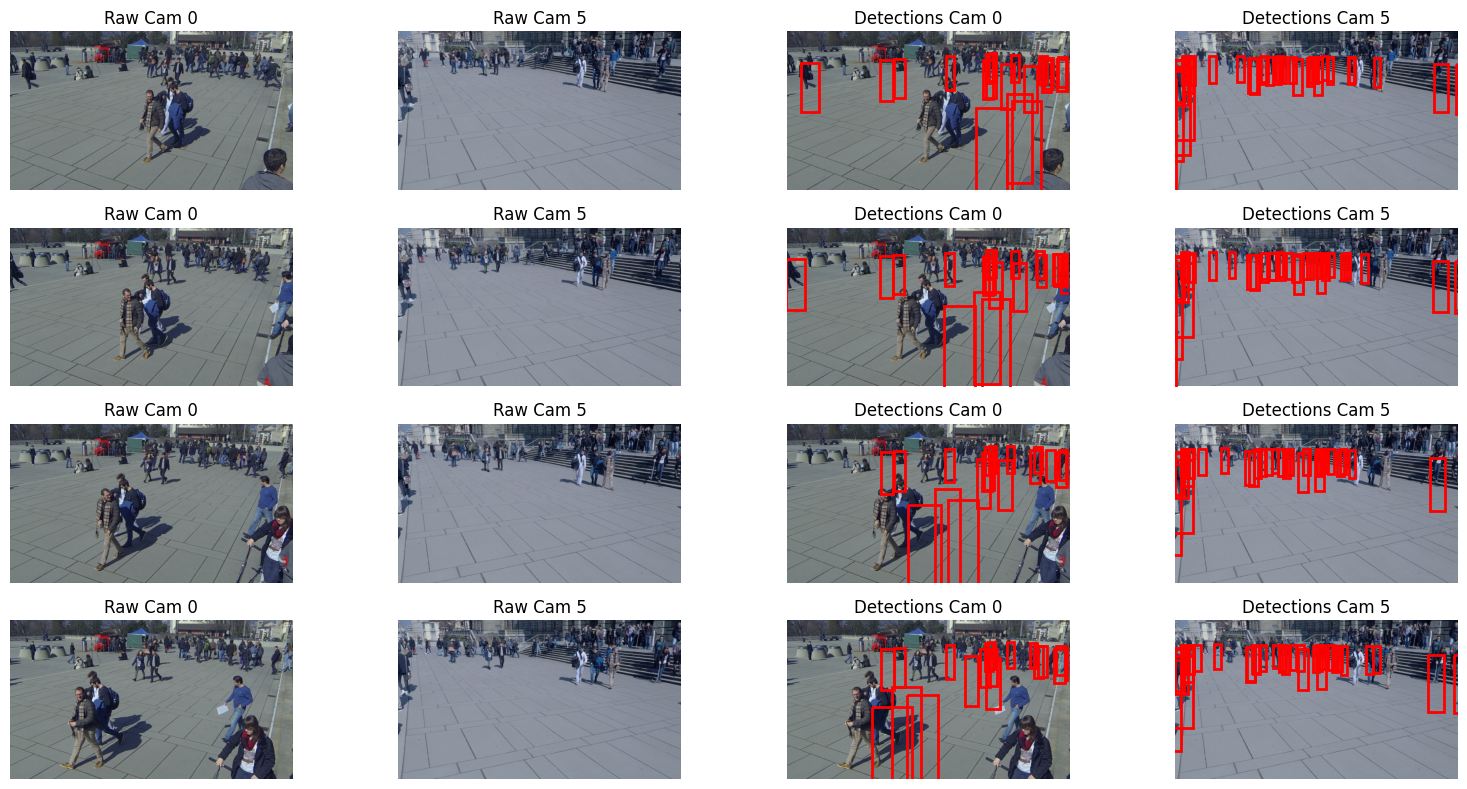

In [70]:
import torch
import matplotlib.pyplot as plt

def show_image_with_boxes(img_tensor, boxes, ax, title=""):
    """
    img_tensor: (C, H, W), torch.Tensor
    boxes: (N, 4), torch.Tensor or np.ndarray, format [x, y, w, h]
    ax: matplotlib axis
    """
    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display
    ax.imshow(img)
    for box in boxes:
        x, y, w, h = box
        if w > 0 and h > 0:
            rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
    ax.set_axis_off()
    ax.set_title(title)

def test_and_visualize(model, dataloader, device, num_batches=2):
    model.eval()
    batch_count = 0
    fig, axes = plt.subplots(4, 4, figsize=(16, 8))
    with torch.no_grad():
        for processed_images, targets in dataloader:
            if batch_count >= num_batches:
                break
            # Move data to device
            inputs = {
                view_num: {
                    'pixel_values': data['pixel_values'].to(device),
                    'pixel_mask': data['pixel_mask'].to(device)
                }
                for view_num, data in processed_images.items()
            }
            # Get raw images for both cameras
            cam1 = list(processed_images.keys())[0]
            cam2 = list(processed_images.keys())[1]
            # First image in batch
            img1 = processed_images[cam1]['pixel_values'][0]
            img2 = processed_images[cam2]['pixel_values'][0]
            # Get detection boxes
            boxes1 = targets['detection_labels'][cam1][0].cpu().numpy()
            boxes2 = targets['detection_labels'][cam2][0].cpu().numpy()
            # Run model (optional, not used for visualization here, but you can use outputs for further analysis)
            outputs = model(inputs)
            # Plot
            show_image_with_boxes(img1, [], axes[batch_count, 0], title=f"Raw Cam {cam1}")
            show_image_with_boxes(img2, [], axes[batch_count, 1], title=f"Raw Cam {cam2}")
            show_image_with_boxes(img1, boxes1, axes[batch_count, 2], title=f"Detections Cam {cam1}")
            show_image_with_boxes(img2, boxes2, axes[batch_count, 3], title=f"Detections Cam {cam2}")
            batch_count += 1
    plt.tight_layout()
    plt.show()

# Usage (run this after training):
test_and_visualize(model, dataloader, device, num_batches=4)


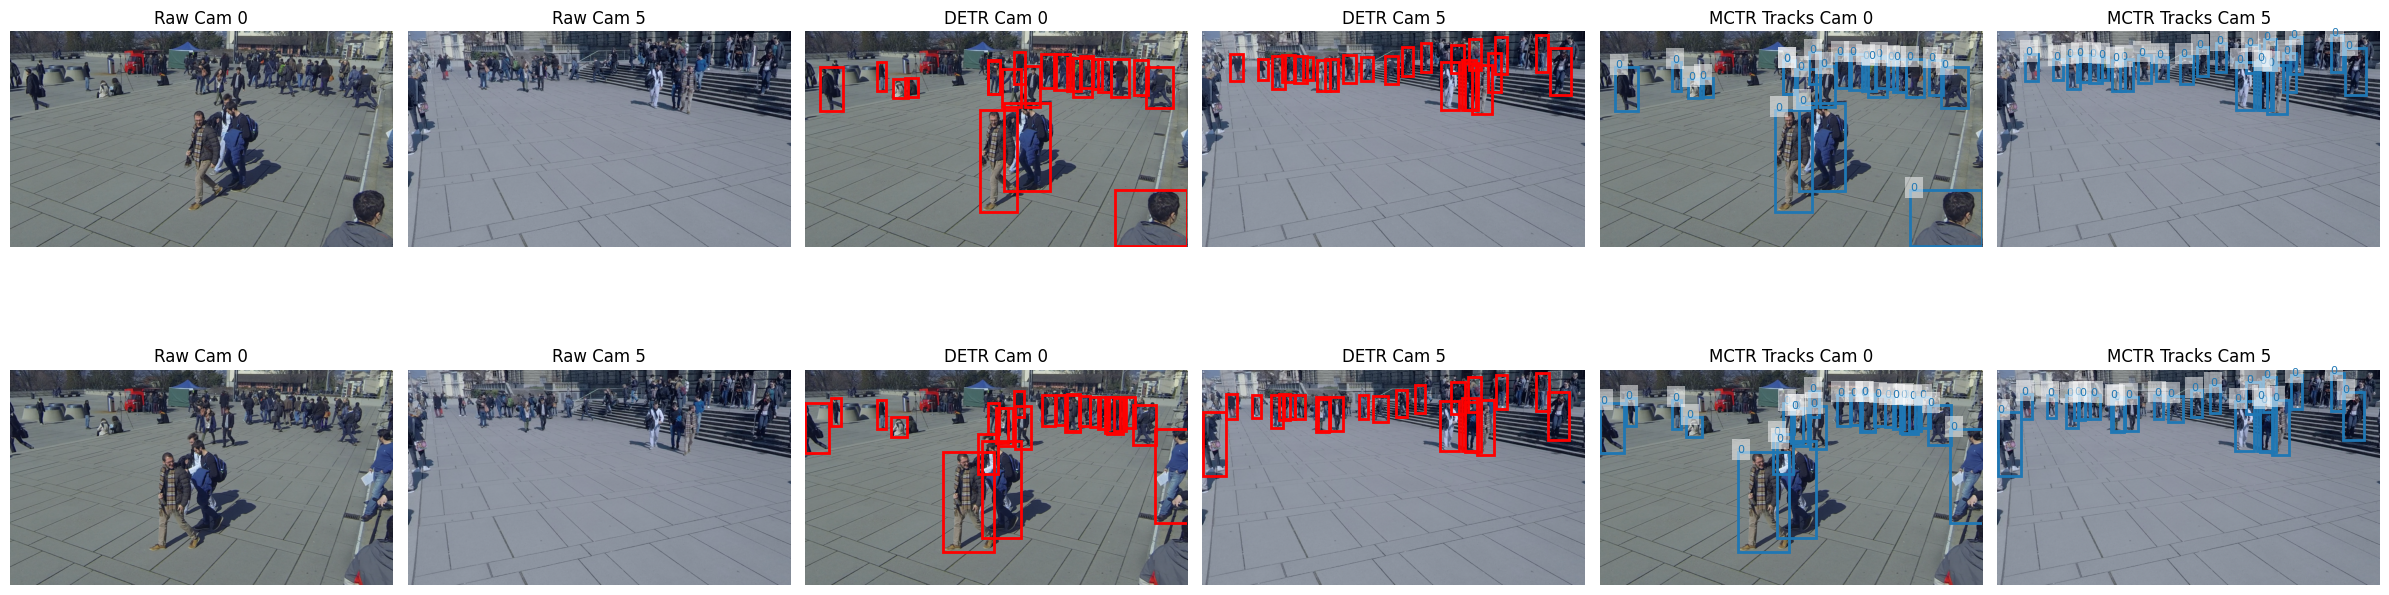

In [71]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_image_with_boxes(img_tensor, boxes, ax, title="", colors=None, labels=None):
    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)
    for i, box in enumerate(boxes):
        x, y, w, h = box
        if w > 0 and h > 0:
            color = colors[i] if colors is not None else 'red'
            rect = plt.Rectangle((x, y), w, h, fill=False, color=color, linewidth=2)
            ax.add_patch(rect)
            if labels is not None:
                ax.text(x, y, str(labels[i]), color=color, fontsize=8, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    ax.set_axis_off()
    ax.set_title(title)

def test_and_visualize(model, dataloader, device, num_batches=2, conf_threshold=0.7):
    model.eval()
    batch_count = 0
    fig, axes = plt.subplots(num_batches, 6, figsize=(24, 4 * num_batches))
    if num_batches == 1:
        axes = axes[None, :]
    with torch.no_grad():
        for processed_images, targets in dataloader:
            if batch_count >= num_batches:
                break
            inputs = {
                view_num: {
                    'pixel_values': data['pixel_values'].to(device),
                    'pixel_mask': data['pixel_mask'].to(device)
                }
                for view_num, data in processed_images.items()
            }
            cam_keys = list(processed_images.keys())
            cam1, cam2 = cam_keys[0], cam_keys[1]
            img1 = processed_images[cam1]['pixel_values'][0]
            img2 = processed_images[cam2]['pixel_values'][0]
            outputs = model(inputs)

            # DETR detections (high-confidence humans)
            detection_logits1 = outputs['detection_logits'][0][0]  # (num_queries, num_classes)
            detection_logits2 = outputs['detection_logits'][1][0]
            pred_boxes1 = outputs['detection_boxes'][0][0].cpu().numpy()  # (num_queries, 4)
            pred_boxes2 = outputs['detection_boxes'][1][0].cpu().numpy()
            scores1 = detection_logits1.softmax(dim=-1)
            scores2 = detection_logits2.softmax(dim=-1)
            person_class_idx = 1  # COCO person class
            keep1 = (scores1[:, person_class_idx] > conf_threshold)
            keep2 = (scores2[:, person_class_idx] > conf_threshold)
            boxes1_filtered = pred_boxes1[keep1.cpu().numpy()]
            boxes2_filtered = pred_boxes2[keep2.cpu().numpy()]

            # MCTR track assignments (show only for high-confidence detections)
            assignments1 = outputs['assignments'][0][0]  # (num_queries, num_tracks)
            assignments2 = outputs['assignments'][1][0]
            # For each high-confidence detection, get the assigned track (argmax)
            assigned_tracks1 = assignments1[keep1].argmax(dim=-1).cpu().numpy() if keep1.any() else np.array([])
            assigned_tracks2 = assignments2[keep2].argmax(dim=-1).cpu().numpy() if keep2.any() else np.array([])
            # Color-code by assigned track
            cmap = plt.get_cmap('tab20')
            colors1 = [cmap(track % 20) for track in assigned_tracks1] if len(assigned_tracks1) else None
            colors2 = [cmap(track % 20) for track in assigned_tracks2] if len(assigned_tracks2) else None

            # Plot all columns for this batch
            show_image_with_boxes(img1, [], axes[batch_count, 0], title=f"Raw Cam {cam1}")
            show_image_with_boxes(img2, [], axes[batch_count, 1], title=f"Raw Cam {cam2}")
            show_image_with_boxes(img1, boxes1_filtered, axes[batch_count, 2], title=f"DETR Cam {cam1}")
            show_image_with_boxes(img2, boxes2_filtered, axes[batch_count, 3], title=f"DETR Cam {cam2}")
            show_image_with_boxes(img1, boxes1_filtered, axes[batch_count, 4], title=f"MCTR Tracks Cam {cam1}", colors=colors1, labels=assigned_tracks1)
            show_image_with_boxes(img2, boxes2_filtered, axes[batch_count, 5], title=f"MCTR Tracks Cam {cam2}", colors=colors2, labels=assigned_tracks2)
            batch_count += 1
    plt.tight_layout()
    plt.show()

# Usage:
test_and_visualize(model, dataloader, device, num_batches=2, conf_threshold=0.7)
